In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from MultiClassCSBM import MultiClassCSBM
from CSBMhet import CSBMhet
from CSBMhom import CSBMhom
from metrics import mmd_rbf, total_variation_distance

import torch
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec

In [2]:
dimensions = 20
gamma = 2 * dimensions
n = 100
classes = 5
training_time = 100

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [5]:
@torch.no_grad()
def test(model, data):
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc

In [6]:
def model_training(csbm):
    data = csbm.data
    model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0).to(device)

    num_workers = 4 if sys.platform == 'linux' else 0
    loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
    accuracy = 0
    for epoch in range(training_time):
        loss = train(model, loader, optimizer)
        acc = test(model, data)
        accuracy = max(acc, accuracy)
    return model.embedding.weight.detach().numpy()

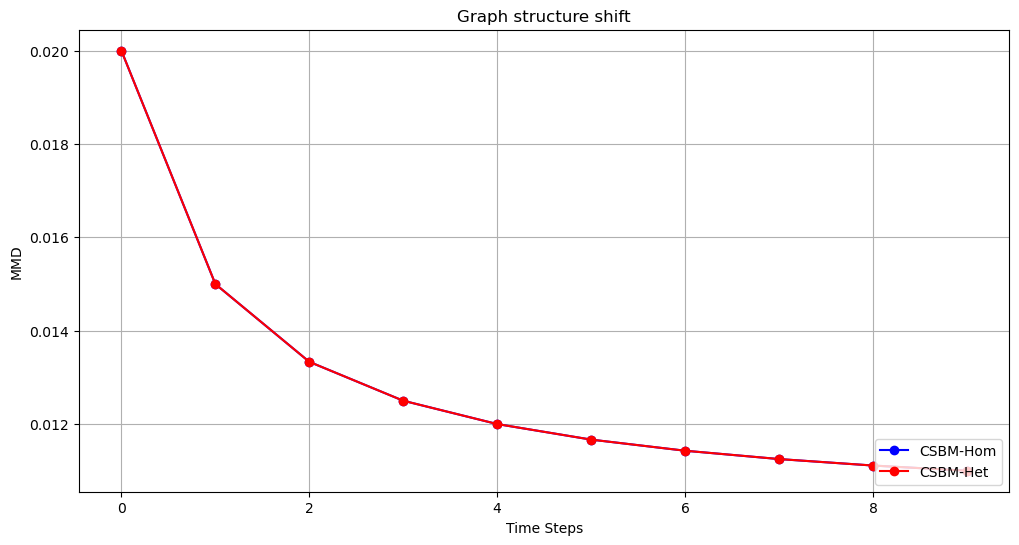

In [7]:
time_steps = []
mmds_hom = []
mmds_het = []
mmds_const = []
csbm_hom = CSBMhom(n=n, dimensions=dimensions, classes=classes, q_hom=0.05)
csbm_het = CSBMhet(n=n, dimensions=dimensions, classes=classes, q_het=0.05)
csbm_const = MultiClassCSBM(n=n, dimensions=dimensions, classes=classes)
initial_embedding_hom = model_training(csbm_hom)
initial_embeddings_het = model_training(csbm_het)
initial_embeddings_const = model_training(csbm_const)
for t in range(10):
    time_steps.append(t)
    embedding_hom = model_training(csbm_hom)
    mmds_hom.append(mmd_rbf(initial_embedding_hom, embedding_hom, gamma))
    embedding_het = model_training(csbm_het)
    mmds_het.append(mmd_rbf(initial_embeddings_het, embedding_het, gamma))
    embedding_const = model_training(csbm_const)
    mmds_const.append(mmd_rbf(initial_embeddings_const, embedding_const, gamma))
    csbm_hom.evolve()
    csbm_het.evolve()
    csbm_const.evolve()

# plot
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmds_hom, marker='o', linestyle='-', color='b', label='CSBM-Hom')
plt.plot(time_steps, mmds_het, marker='o', linestyle='-', color='r', label='CSBM-Het')
#plt.plot(time_steps, mmds_const, marker='o', linestyle='-', color='black', label='Const. CSBM')

plt.title('Graph structure shift')
plt.xlabel('Time Steps')
plt.ylabel('MMD')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift.pdf', format='pdf')
plt.show()
plt.close()